### Libraries

In [6]:
# Libraries:
import ta
import pandas as pd
import numpy as np
import yfinance as yf
from ta import add_all_ta_features
from ta.utils import dropna
from sklearn.preprocessing import StandardScaler
from ta.trend import MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
import statsmodels.api as sm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


### Data set Function and database

In [8]:
# Function: get data
def fetch_stock_data(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    df = stock.history(start=start_date, end=end_date)
    df = df.drop(df.iloc[:, 5:8], axis=1)
    
    return df


In [9]:
# dataset
ticker = "AAPL"
df = fetch_stock_data(ticker,"2000-01-01","2025-03-25")
df =df.dropna()
print(df.info())
df.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6344 entries, 2000-01-03 00:00:00-05:00 to 2025-03-24 00:00:00-04:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    6344 non-null   float64
 1   High    6344 non-null   float64
 2   Low     6344 non-null   float64
 3   Close   6344 non-null   float64
 4   Volume  6344 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 297.4 KB
None


,Open,High,Low,Close,Volume
Date,,,,,
2025-03-18 00:00:00-04:00,214.160004,215.149994,211.490005,212.690002,42432400
2025-03-19 00:00:00-04:00,214.220001,218.759995,213.750000,215.240005,54385400
2025-03-20 00:00:00-04:00,213.990005,217.490005,212.220001,214.100006,48862900
2025-03-21 00:00:00-04:00,211.559998,218.839996,211.279999,218.270004,94127800
2025-03-24 00:00:00-04:00,221.000000,221.479996,218.580002,220.729996,44299500


### Indicators' Functions

In [ ]:
# Functions: safe access
def safe_access(df, column):
    try:
        return df[column]
    except KeyError:
        print(f"Column '{column}' not found in DataFrame.")
        return pd.Series([np.nan] * len(df), index=df.index)  # Return a Series with NaN values

In [ ]:
# Function 1: calculate indicators
def calculate_indicators(df, nan_threshold=0.1):
    print("Step 1: Calculating all indicators using ta library...")
    df_indicators = add_all_ta_features( # assigning the value to df
        df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True
    )
    print("All indicators calculated using ta library.")

    print("\nStep 2: Manually calculating SMA_50 and SMA_200 indicators...")
    df_indicators['SMA_50'] = df_indicators['Close'].rolling(window=50).mean()
    df_indicators['SMA_200'] = df_indicators['Close'].rolling(window=200).mean()
    print("SMA_50 and SMA_200 Calculated")

    print("\nStep 3: Calculating the percentage of NaNs for each indicator...")
    nan_percentages = df_indicators.isna().mean()
    print("NaN percentages calculated.")

    print("\nStep 4: Identifying indicators with high NaN percentages...")
    high_nan_indicators = nan_percentages[nan_percentages > nan_threshold].index.tolist()
    print(f"Indicators with more than {nan_threshold*100}% NaNs: {high_nan_indicators}")

    print("\nStep 5: Removing high NaN indicators from the DataFrame...")
    df_filtered = df_indicators.drop(columns=high_nan_indicators)
    for indicator in high_nan_indicators:
        print(f"Deleted indicator due to high NaN: {indicator}")
    print("High NaN indicators removed.")

    print("\nStep 6: Manually calculating SMA_50 and SMA_200 indicators...")
    df_filtered['SMA_50'] = df_filtered['Close'].rolling(window=50).mean()
    df_filtered['SMA_200'] = df_filtered['Close'].rolling(window=200).mean()

    print("\nStep 7: Manually recalculating removed indicators...")
    for indicator in high_nan_indicators:
        print(f"Recalculating: {indicator}")
        if indicator.startswith('trend_sma'):
            window = int(indicator.split('_')[-1])
            df_filtered[indicator] = df['Close'].rolling(window=window).mean()
        elif indicator.startswith('trend_ema'):
            window = int(indicator.split('_')[-1])
            df_filtered[indicator] = df['Close'].ewm(span=window, adjust=False).mean()
        elif indicator == 'trend_macd':
            exp1 = df['Close'].ewm(span=12, adjust=False).mean()
            exp2 = df['Close'].ewm(span=26, adjust=False).mean()
            df_filtered[indicator] = exp1 - exp2
        elif indicator == 'trend_macd_signal':
            exp1 = df['Close'].ewm(span=12, adjust=False).mean()
            exp2 = df['Close'].ewm(span=26, adjust=False).mean()
            macd = exp1 - exp2
            df_filtered[indicator] = macd.ewm(span=9, adjust=False).mean()
        elif indicator == 'trend_macd_diff':
            exp1 = df['Close'].ewm(span=12, adjust=False).mean()
            exp2 = df['Close'].ewm(span=26, adjust=False).mean()
            macd = exp1 - exp2
            signal = macd.ewm(span=9, adjust=False).mean()
            df_filtered[indicator] = macd - signal
        elif indicator.startswith('momentum_rsi'):
            window = int(indicator.split('_')[-1]) if len(indicator.split('_')) > 2 else 14
            delta = df['Close'].diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
            rs = gain / loss
            df_filtered[indicator] = 100 - (100 / (1 + rs))
        elif indicator.startswith('volatility_bbm'):
            window = int(indicator.split('_')[-1]) if len(indicator.split('_')) > 2 else 20
            std = df['Close'].rolling(window=window).std()
            df_filtered[indicator] = df['Close'].rolling(window=window).mean()
            df_filtered[f'volatility_bbh_{window}'] = df_filtered[indicator] + 2 * std
            df_filtered[f'volatility_bbl_{window}'] = df_filtered[indicator] - 2 * std
        # Add more conditions for other indicators as needed
        else:
            print(f"Warning: No manual calculation method for {indicator}")
    print("Manual recalculation of removed indicators completed.")

    print("\nStep 8: Combining original data with calculated indicators...")
    result_df = pd.concat([df, df_filtered], axis=1)
    print("Data combined.")

    print("\nStep 9: Checking for NaNs in the final DataFrame...")
    final_nan_percentages = result_df.isna().mean()
    print("Percentage of NaNs in the final DataFrame:")
    for column, percentage in final_nan_percentages[final_nan_percentages > 0].items():
        print(f"{column}: {percentage*100:.2f}%")

    print("\nStep 10: Filling remaining NaN values with column means...")
    result_df = result_df.fillna(result_df.mean())
    print("Remaining NaN values filled with column means.")

    return result_df

In [ ]:
#Function 2: Calculate indicators
def calculate_indicators(df, nan_threshold=1.0): # CHANGE HERE
    print("Step 1: Calculating all indicators using ta library...")
    df = add_all_ta_features( # assigning the value to df
        df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True
    )
    print("All indicators calculated using ta library.")

    # Manually calculate SMA_50 and SMA_200
    print("Step 1b: Calculating SMA_50 and SMA_200")
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['SMA_200'] = df['Close'].rolling(window=200).mean()
    print("SMA_50 and SMA_200 Calculated")

    print("\nStep 2: Checking for NaNs in SMA_50 and SMA_200")
    print(f"NaN percentage in SMA_50: {df['SMA_50'].isnull().sum() / len(df) * 100:.2f}%")
    print(f"NaN percentage in SMA_200: {df['SMA_200'].isnull().sum() / len(df) * 100:.2f}%")

    print("\nStep 3: Calculating the percentage of NaNs for each indicator...")
    nan_percentages = df.isna().mean()
    print("NaN percentages calculated.")

    print("\nStep 4: Identifying indicators with high NaN percentages...")
    high_nan_indicators = nan_percentages[nan_percentages > nan_threshold].index.tolist()
    print(f"Indicators with more than {nan_threshold*100}% NaNs: {high_nan_indicators}")

    print("\nStep 5: Filling remaining NaN values with column means...")
    result_df = df.fillna(df.mean())
    print("Remaining NaN values filled with column means.")

    return result_df

In [ ]:
# Function: analyze_trend
def analyze_trend(df):
    sma_50 = df['SMA_50']
    sma_200 = df['SMA_200']
    common_index = sma_50.index.intersection(sma_200.index)
    sma_50 = sma_50.loc[common_index]
    sma_200 = sma_200.loc[common_index]

    if sma_50.empty or sma_200.empty:
        return "Insufficient data for trend analysis"

    # Compare the last values of each SMA
    if sma_50.iloc[-1] > sma_200.iloc[-1]:
        return "Uptrend"
    elif sma_50.iloc[-1] < sma_200.iloc[-1]:
        return "Downtrend"
    else:
        return "Sideways"

In [ ]:
# Function 2: analyze_trend
# Updated analyze_trend function
def analyze_trend(df):
    sma_50 = safe_access(df, 'SMA_50')
    sma_200 = safe_access(df, 'SMA_200')

    if sma_50.isnull().all() or sma_200.isnull().all():
        return "Insufficient data for trend analysis"

    # Compare the last values of each SMA
    if sma_50.iloc[-1] > sma_200.iloc[-1]:
        return "Uptrend"
    elif sma_50.iloc[-1] < sma_200.iloc[-1]:
        return "Downtrend"
    else:
        return "Sideways"


In [ ]:
# Function: analyze_momentum
# Updated analyze_momentum function
def analyze_momentum(df):
    rsi = safe_access(df, 'momentum_rsi')

    if isinstance(rsi, str):
        return "Column 'momentum_rsi' not found, cannot perform momentum analysis."

    if rsi.isnull().all():
        return "Insufficient data for momentum analysis"

    if rsi.iloc[-1] > 70:
        return "Overbought"
    elif rsi.iloc[-1] < 30:
        return "Oversold"
    else:
        return "Neutral"

In [ ]:
# Function: analyze_volatility
def analyze_volatility(df):
    bb_high = safe_access(df, 'volatility_bbh')
    bb_low = safe_access(df, 'volatility_bbl')
    close = safe_access(df, 'Close')
    
    if bb_high.isnull().all() or bb_low.isnull().all():
        return "Insufficient data for volatility analysis"
    
    # Compare the last values of each series
    last_close = close.iloc[-1]
    last_bb_high = bb_high.iloc[-1]
    last_bb_low = bb_low.iloc[-1]

    if last_close > last_bb_high:
        return "High volatility (above upper Bollinger Band)"
    elif last_close < last_bb_low:
        return "High volatility (below lower Bollinger Band)"
    else:
        return "Normal volatility"

In [ ]:
# Function: analyze_volum
def analyze_volume(df):
    obv = df['volume_obv']
    if len(obv) < 2:
        return "Insufficient data for volume analysis"
    
    if obv.iloc[-1] > obv.iloc[-2]:
        return "Increasing"
    elif obv.iloc[-1] < obv.iloc[-2]:
        return "Decreasing"
    else:
        return "Stable"


In [ ]:
# Function: generate_signal
def generate_signal(trend, momentum, volatility, volume):
    if trend == "Uptrend" and momentum != "Overbought" and volume == "Increasing":
        return "Strong Buy"
    elif trend == "Uptrend" and momentum == "Neutral":
        return "Buy"
    elif trend == "Downtrend" and momentum != "Oversold" and volume == "Decreasing":
        return "Strong Sell"
    elif trend == "Downtrend" and momentum == "Neutral":
        return "Sell"
    else:
        return "Hold"

In [ ]:
# Get indicators
df = calculate_indicators(df)
df.tail()

Step 1: Calculating all indicators using ta library...


c:\Desktop\python_projects\project_env\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


All indicators calculated using ta library.
Step 1b: Calculating SMA_50 and SMA_200
SMA_50 and SMA_200 Calculated

Step 2: Checking for NaNs in SMA_50 and SMA_200
NaN percentage in SMA_50: 0.77%
NaN percentage in SMA_200: 3.14%

Step 3: Calculating the percentage of NaNs for each indicator...
NaN percentages calculated.

Step 4: Identifying indicators with high NaN percentages...
Indicators with more than 100.0% NaNs: []

Step 5: Filling remaining NaN values with column means...
Remaining NaN values filled with column means.


,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,SMA_50,SMA_200
Date,,,,,,,,,,,,,,,,,,,,,
2025-03-17 00:00:00-04:00,213.309998,215.220001,209.970001,214.000000,48073400,8.106582e+10,104667753800,-0.053010,-1.295358e+08,9.064284,...,-1.360107,4.299377,2.865017,1.434360,222.964777,0.238884,0.238600,25311.134663,234.072993,227.473337
2025-03-18 00:00:00-04:00,214.160004,215.149994,211.490005,212.690002,42432400,8.105121e+10,104625321400,-0.095102,-1.189716e+08,6.253443,...,-1.264791,1.990663,2.690146,-0.699483,221.151841,-0.612148,-0.614030,25155.580811,233.455149,227.588524
2025-03-19 00:00:00-04:00,214.220001,218.759995,213.750000,215.240005,54385400,8.102917e+10,104679706800,-0.120357,-8.216384e+07,27.037259,...,-1.053981,1.904333,2.532984,-0.628650,220.383984,1.198929,1.191799,25458.377404,232.898094,227.711478
2025-03-20 00:00:00-04:00,213.990005,217.490005,212.220001,214.100006,48799300,8.101519e+10,104630907500,-0.138891,-7.837345e+07,-15.119016,...,-0.884111,0.983404,2.223068,-1.239664,219.543761,-0.529641,-0.531049,25323.009750,232.285476,227.823948
2025-03-21 00:00:00-04:00,211.514999,215.479996,211.470001,215.160004,34288245,8.104401e+10,104665195745,-0.072391,-6.198504e+07,-16.139094,...,-0.683166,-2.006683,1.377118,-3.383801,218.746222,0.495095,0.493873,25448.877697,231.749796,227.932847


In [ ]:
# get other analysis
trend = analyze_trend(df)
momentum = analyze_momentum(df)
volatility = analyze_volatility(df)
volume = analyze_volume(df)

print(f"\nTechnical Analysis for {ticker}:")
print(f"Trend: {trend}")
print(f"Momentum: {momentum}")
print(f"Volatility: {volatility}")
print(f"Volume: {volume}")


Technical Analysis for AAPL:
Trend: Uptrend
Momentum: Neutral
Volatility: Normal volatility
Volume: Increasing


In [ ]:
# give signal
try:
    if "Insufficient data" not in [trend, momentum, volatility, volume]:
        signal = generate_signal(trend, momentum, volatility, volume)
        print(f"\nSignal: {signal}")

        if signal == "Strong Buy" or signal == "Buy":
            print("Suggestion: Consider opening a long position.")
        elif signal == "Strong Sell" or signal == "Sell":
            print("Suggestion: Consider opening a short position or selling existing holdings.")
        else:
            print("Suggestion: Monitor the stock closely for potential entry or exit opportunities.")
    else:
        print("\nUnable to generate a signal due to insufficient data.")

except Exception as e:
    print(f"An error occurred: {str(e)}")
    print("Please check your input parameters and ensure all required libraries are installed.")



Signal: Strong Buy
Suggestion: Consider opening a long position.


### CAPM function

In [ ]:
# Finding best period for capm using volatility --> not in use
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import datetime, timedelta

def calculate_volatility(returns):
    return returns.std() * np.sqrt(252)  # Annualized volatility

def calculate_beta(stock_returns, market_returns):
    X = sm.add_constant(market_returns.dropna())  # Add constant term
    y = stock_returns.loc[X.index]  # Ensure aligned indexes
    if len(X) < 2:  # Ensure enough data points for regression
        return np.nan
    model = sm.OLS(y, X).fit()
    return model.params[1]

def calculate_capm(risk_free_rate, beta, market_return):
    return risk_free_rate + beta * (market_return - risk_free_rate)

def analyze_stock(ticker, market_index='^GSPC', max_period=5):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=max_period*365)

    # Fetch stock and market data
    stock_data = yf.download(ticker, start=start_date, end=end_date)['Close']
    market_data = yf.download(market_index, start=start_date, end=end_date)['Close']
    
    if stock_data.empty or market_data.empty:
        raise ValueError(f"Failed to fetch data for {ticker} or {market_index}")
    
    # Calculate daily returns
    stock_returns = stock_data.pct_change().dropna()
    market_returns = market_data.pct_change().dropna()

    # Calculate volatilities and betas
    volatilities, betas = {}, {}
    for period in range(1, max_period + 1):
        period_start = end_date - timedelta(days=period*365)
        period_stock_returns = stock_returns.loc[stock_returns.index >= period_start]
        period_market_returns = market_returns.loc[market_returns.index >= period_start]

        if not period_stock_returns.empty and not period_market_returns.empty:
            volatilities[period] = calculate_volatility(period_stock_returns)
            betas[period] = calculate_beta(period_stock_returns, period_market_returns)
    
    # Handle case where not enough data is available
    if len(volatilities) < 2 or len(betas) < 2:
        raise ValueError("Not enough data to calculate stable volatility and beta.")

    # Choose the most stable period based on volatility changes
    # Ensure volatility_changes is not empty before finding the min
    

    # Convert values to numeric scalars (avoid Series-related errors)
    volatility_changes = {p: float(abs(volatilities[p] - volatilities[p - 1])) for p in range(2, max_period + 1)}
    if not volatility_changes:
        raise ValueError("Not enough stable volatility data available.")
    # Find the most stable period
    else:
        most_stable_period = min(volatility_changes, key=volatility_changes.get)
        final_beta = round(float(betas[most_stable_period]),4)

    

    # Get risk-free rate from 10-year Treasury yield
    try:
        risk_free_rate = yf.Ticker('^TNX').info.get('regularMarketPrice', 2) / 100  # Default to 2% if missing
    except:
        risk_free_rate = 0.02  # Fallback value
    
    # Calculate expected return using CAPM
    market_return = round(market_returns.mean() * 252,4)  # Annualized return
    expected_return = round(calculate_capm(risk_free_rate, final_beta, market_return),4)

    return {
        'ticker': ticker,
        'period_used': most_stable_period,
        'beta': final_beta,
        'CAPM': expected_return,
        'Market Return': market_return
    }


In [ ]:
analyze_stock(ticker, market_index='^GSPC', max_period=5)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
C:\Users\smahd\AppData\Local\Temp\ipykernel_19076\4009285744.py:16: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\smahd\AppData\Local\Temp\ipykernel_19076\4009285744.py:16: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\smahd\AppData\Local\Temp\ipykernel_19076\4009285744.py:16: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acces

{'ticker': 'AAPL',
 'period_used': 4,
 'beta': 1.2008,
 'CAPM': Ticker
 ^GSPC    0.1996
 dtype: float64,
 'Market Return': Ticker
 ^GSPC    0.1735
 dtype: float64}

In [7]:
# check if rate can be downloaded correctly
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

max_period = 5  # Maximum period in years
end_date = datetime.now().date()  # Only the date part
start_date = end_date - timedelta(days=max_period * 365)
# Download risk-free rate data
risk_free_rate = yf.download("^IRX", start=start_date, end=end_date)
risk_free_rate = risk_free_rate['Close'].iloc[-1]
print("Risk-Free Rate:", risk_free_rate)


[*********************100%***********************]  1 of 1 completed

Risk-Free Rate: Ticker
^IRX    4.188
Name: 2025-03-27 00:00:00, dtype: float64


In [9]:
# getting stock and market data directly not via function
stock_data = yf.Ticker("AAPL").history(period="max", interval="1d")
market_data = yf.Ticker("^GSPC").history(period="max", interval="1d")
rf_data = yf.Ticker("^FVX").history(period="max", interval="1d")
# stock_data, market_data, rf_data .reset_index(inplace=True)
# stock_data["Date"], market_data["Date"] = pd.to_datetime(stock_data["Date"]).dt.strftime("%Y-%m-%d")

stock_data.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-03-26 00:00:00-04:00,223.509995,225.020004,220.470001,221.529999,34532700,0.0,0.0
2025-03-27 00:00:00-04:00,221.389999,224.990005,220.559998,223.850006,37049500,0.0,0.0


In [ ]:
#This gives error
import yfinance as yf
import pandas as pd

max_period = 5
end_date = datetime.now()
start_date = end_date - timedelta(days=max_period*365)


def get_stock_data(stock_data, market_data, rf_data, start_date, end_date):
    # Convert all indices to timezone-naive datetime objects
    for df in [stock_data, market_data, rf_data]:
        if not isinstance(df.index, pd.DatetimeIndex):
            df.index = pd.to_datetime(df.index)
        # Remove timezone information if present
        if df.index.tz is not None:
            df.index = df.index.tz_localize(None)
    
    # Convert start/end dates to datetime (timezone-naive)
    start_date = pd.to_datetime(start_date).tz_localize(None)
    end_date = pd.to_datetime(end_date).tz_localize(None)
    
    # Filter data based on start and end dates
    stock_data = stock_data.loc[start_date:end_date]
    market_data = market_data.loc[start_date:end_date]
    rf_data = rf_data.loc[start_date:end_date]
    
    # Combine data into a single DataFrame
    # combined_data = pd.concat([
    #     stock_data['Close'].rename('Stock'),
    #     market_data['Close'].rename('Market'),
    #     rf_data['Close'].rename('Risk_Free')
    # ], axis=1)

    # Ensure we have matching dates for both datasets
    common_dates = stock_data.index.intersection(market_data.index)
    stock_returns = stock_data.loc[common_dates, 'stock_returns']
    market_returns = market_data.loc[common_dates, 'market_returns']
    
    # # Format the index to 'YYYY-MM-DD' and drop NaN values
    # combined_data.index = combined_data.index.strftime('%Y-%m-%d')
    # return combined_data.dropna()

# Example usage:
# Assuming stock_data, market_data, and rf_data are pre-existing DataFrames
# start_date and end_date are pre-calculated dates (strings or datetime objects)
df = get_stock_data(stock_data, market_data, rf_data, start_date, end_date)
print(df.head())
print(f"Shape of the DataFrame: {df.shape}")

KeyError: 'stock_returns'

In [ ]:
# Create the datasets into one df
def data(stock_data, market_data, rf_data, start_date, end_date):
    return pd.concat([df['Close'].rename(name) 
                      for df, name in zip([stock_data, market_data, rf_data], 
                                        ['Stock', 'Market', 'Risk_Free'])], axis=1) \
             .loc[start_date:end_date] \
             .dropna() \
             .pipe(lambda df: df.set_index(df.index.strftime('%Y-%m-%d')))

# Usage:
df = data(stock_data, market_data, rf_data, start_date, end_date)
print(df.tail())

                 Stock       Market  Risk_Free
Date                                          
2025-03-18  212.690002  5614.660156      4.195
2025-03-19  215.240005  5675.290039      4.190
2025-03-20  214.100006  5662.890137      4.182
2025-03-21  218.270004  5667.560059      4.185
2025-03-24  220.729996  5767.569824      4.182


In [ ]:
stock_data = stock_data[(stock_data["Date"])]

In [ ]:
# CAPM function 3: notin use
# import pandas as pd
# import numpy as np
# import yfinance as yf
# from datetime import datetime, timedelta
# import statsmodels.api as sm


# def capm(stock_data, market_data, rf):

#     # start and end data
#     max_period = 5
#     end_date = datetime.now()
#     start_date = end_date - timedelta(days=max_period*365)

#     # Get data
#     def data(stock_data, market_data, rf_data, start_date, end_date):
#         return pd.concat([df['Close'].rename(name) 
#                       for df, name in zip([stock_data, market_data, rf_data], 
#                                         ['Stock', 'Market', 'Risk_Free'])], axis=1) \
#              .loc[start_date:end_date] \
#              .dropna() \
#              .pipe(lambda df: df.set_index(df.index.strftime('%Y-%m-%d')))
    
#     # volatility calculation
#     def calc_volatility(returns):
#         return returns.std() * np.sqrt(252)  # Annualized volatility
    
#     # # Beta calculation
#     def calc_beta(stock_returns, market_returns):
#         X = sm.add_constant(market_returns.dropna())  # Add constant term
#         y = stock_returns.loc[X.index]  # Ensure aligned indexes
#         if len(X) < 2:  # Ensure enough data points for regression
#             return np.nan
#         model = sm.OLS(y, X).fit()
#         return model.params[1]
    
#     # # calculate capm
#     def calc_capm(risk_free_rate, beta, market_return):
#         return risk_free_rate + beta * (market_return - risk_free_rate)

#     ## create data frame (stock, market, rf)
#     df = data(stock_data, market_data, rf, start_date, end_date)

#     # Convert index to datetime if not already
#     df.index = pd.to_datetime(df.index)

#     ## Calculate daily returns and risk free
#     df["Stock_returns"]= df["Stock"].pct_change().dropna()
#     df["Market_returns"]= df["Market"].pct_change().dropna()
    

#     # calculate volatilities and betas
#     volatilities, betas = {}, {}
#     for period in range(1,max_period + 1):
#         period_start = end_date - timedelta(days=period*365)
#         period_stock_returns = df['Stock_returns'].loc[df.index >= period_start]
#         period_market_returns = df['Market_returns'].loc[df.index >= period_start]

#         if not period_stock_returns.empty and not period_market_returns.empty:
#             volatilities[period] = calc_volatility(period_stock_returns)
#             betas[period] = calc_beta(period_stock_returns, period_market_returns)

#     # Handle case where not enough data is available
#     if len(volatilities) < 2 or len(betas) < 2:
#         raise ValueError("Not enough data to calculate stable volatility and beta.")

#     # Choose the most stable period based on volatility changes
#     # Convert values to numeric scalars (avoid Series-related errors)
#     volatility_changes = {p: float(abs(volatilities[p] - volatilities[p - 1])) for p in range(2, max_period + 1)}
#     if not volatility_changes:
#         raise ValueError("Not enough stable volatility data available.")
#     # Find the most stable period
#     else:
#         most_stable_period = min(volatility_changes, key=volatility_changes.get)
#         final_beta = round(float(betas[most_stable_period]),4)
    
#     # Calculate market expeted return, capm, actual stock retrun, risk free rate
#     rf = df["Risk_Free"].iloc[-1]
#     stock_actual_return = round(df["Stock_returns"].iloc[-1],4)*100
#     m_return =round((1 + df["Market_returns"].mean()) ** 252 -1, 4)*100

#     capm = round(calc_capm(rf, final_beta, m_return),4)
    
#     return stock_actual_return,capm, m_return, most_stable_period, final_beta
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import statsmodels.api as sm

def capm(stock_data, market_data, rf):
    # Start and end date
    max_period = 5
    end_date = pd.Timestamp.now().tz_localize(None)
    start_date = end_date - timedelta(days=max_period*365)

    # Get data
    def data(stock_data, market_data, rf_data, start_date, end_date):
        dfs = [stock_data, market_data, rf_data]
        names = ['Stock', 'Market', 'Risk_Free']
        
        for df in dfs:
            df.index = pd.to_datetime(df.index).tz_localize(None)
        
        return pd.concat([df['Close'].rename(name) for df, name in zip(dfs, names)], axis=1) \
                 .loc[start_date:end_date] \
                 .dropna()

    # Volatility calculation
    def calc_volatility(returns):
        return returns.std() * np.sqrt(252)  # Annualized volatility
    
    # Beta calculation
    def calc_beta(stock_returns, market_returns):
        X = sm.add_constant(market_returns.dropna())
        y = stock_returns.loc[X.index]
        if len(X) < 2:
            return np.nan
        model = sm.OLS(y, X).fit()
        return model.params[1]
    
    # Calculate CAPM
    def calc_capm(risk_free_rate, beta, market_return):
        return risk_free_rate + beta * (market_return - risk_free_rate)

    # Create data frame (stock, market, rf)
    df = data(stock_data, market_data, rf, start_date, end_date)

    # Calculate daily returns
    df["Stock_returns"] = df["Stock"].pct_change().dropna()
    df["Market_returns"] = df["Market"].pct_change().dropna()

    # Calculate volatilities and betas
    volatilities, betas = {}, {}
    for period in range(1, max_period + 1):
        period_start = end_date - timedelta(days=period*365)
        period_data = df.loc[df.index >= period_start]
        
        if len(period_data) > 1:
            volatilities[period] = calc_volatility(period_data['Stock_returns'])
            betas[period] = calc_beta(period_data['Stock_returns'], period_data['Market_returns'])

    # Handle case where not enough data is available
    if len(volatilities) < 2 or len(betas) < 2:
        raise ValueError("Not enough data to calculate stable volatility and beta.")

    # Choose the most stable period based on volatility changes
    volatility_changes = {p: abs(volatilities[p] - volatilities[p - 1]) for p in range(2, max_period + 1) if p-1 in volatilities}
    if not volatility_changes:
        raise ValueError("Not enough stable volatility data available.")
    
    most_stable_period = min(volatility_changes, key=volatility_changes.get)
    final_beta = round(betas[most_stable_period], 4)
    
    # Calculate market expected return, CAPM, actual stock return, risk-free rate
    rf = df["Risk_Free"].iloc[-1]
    stock_actual_return = round(df["Stock_returns"].iloc[-1], 4)
    m_return = round((1 + df["Market_returns"].mean()) ** 252 - 1, 4)

    capm_result = round(calc_capm(rf, final_beta, m_return/100), 4)
    
    return stock_actual_return, capm_result, m_return, most_stable_period, final_beta


In [ ]:
# Get data without function
stock_data = yf.Ticker("AAPL").history(period=f"{max_period}y", interval="1d")
market_data = yf.Ticker("^GSPC").history(period=f"{max_period}y", interval="1d")
rf_data = yf.Ticker("^FVX").history(period=f"{max_period}y", interval="1d")

In [ ]:
# Old version of getting data function
def load_history(symbol):
    stock = yf.Ticker(symbol)
    df_hm =stock.history(period="max")
    df_hm.reset_index(inplace=False)
    return df_hm

In [ ]:
# version 2 of getting data function, donnot use it
# def load_history1(symbol):
#     try:
#         stock = yf.Ticker(symbol)
#         df_hm = stock.history(period='max')
#         df_hm.index = pd.to_datetime(df_hm.index)
#         #df_hm.index = df_hm.index.tz_localize(None)
#         if df_hm.empty:
#             print(f"No data available for {symbol}")
#             return None
#         return df_hm
#     except Exception as e:
#         print(f"Error loading data for {symbol}: {e}")
#         return None


In [11]:
# Version 3 of getting data with period and interval option
def load_history(symbol, period, interval):
    try:
        print(period)
        print(interval)
        stock = yf.Ticker(symbol)
        df_hm = stock.history(period=period, interval=interval)
        if df_hm.empty:
            print(f"No data available for {symbol}")
            return None
        return df_hm
    except Exception as e:
        print(f"Error loading data for {symbol}: {e}")
        return None

In [13]:
# Use the version 3 of getting data function
stock_data = load_history('AAPL', 'max', '1d')
market_data = load_history('^Gspc', 'max', '1d')
rf_data = load_history('^FVX', 'max', '1d')

max
1d
max
1d
max
1d


In [14]:
# Check rf_data has the data
rf_data.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-03-26 00:00:00-05:00,4.091,4.111,4.072,4.083,0,0.0,0.0
2025-03-27 00:00:00-05:00,4.119,4.120,4.080,4.098,0,0.0,0.0


In [ ]:
# Version 1 of using CAPM function
# This version
import pandas as pd
def capm_v1(stock_data, market_data):
    
    max_period = 5
    end_date = pd.Timestamp.now().tz_localize(None)
    start_date = end_date - timedelta(days=max_period*365)

    # Risk-free data: for simplicity used 5y US T-bill
    rf_data = yf.Ticker('^FVX')
    rf_data = rf_data.history(period=f'{max_period}y', interval='1d')
    rf_rate = rf_data['Close'].iloc[-1] / 100  # Convert to decimal



    # Calculate daily returns for stock and market
    stock_data['stock_returns'] = stock_data['Close'].pct_change().dropna()
    market_data['market_returns'] = market_data['Close'].pct_change().dropna()

    # Filter dataset based on start and end date
    stock_data = stock_data.loc[start_date:end_date]
    market_data = market_data.loc[start_date:end_date]

    # Ensure we have matching dates for both datasets
    common_dates = stock_data.index.intersection(market_data.index)
    stock_returns = stock_data.loc[common_dates, 'stock_returns']
    market_returns = market_data.loc[common_dates, 'market_returns']

    # Beta calculation
    if len(common_dates) < 2:  # Ensure enough data points for regression
        print("np.nan, np.nan, np.nan, np.nan")
    else:
        X = sm.add_constant(market_returns)
        y = stock_returns
        model = sm.OLS(y, X, missing='drop').fit()
        beta = model.params[1]
        #print(f"Beta: {beta}")
    # Calculate market expected return, CAPM, actual stock return
    stock_actual_return = (stock_data['stock_returns'].iloc[-1])
    m_return = (1 + market_data['market_returns'].mean()) ** 252 - 1
    market_actual_return = (market_data['market_returns'].iloc[-1]) 

    capm_return = rf_rate + beta * (m_return - rf_rate)
    return capm_return, beta, m_return, stock_actual_return, market_actual_return
    #print(f'camp: {capm_return*100}\nrisk_free rate: {rf_rate*100}\nMarket_return: {m_return*100}\nStock actual retrun:{stock_actual_return*100}\nMarket actual return:{market_actual_return*100}')

In [18]:
# Version 2 of using CAPM function
import numpy as np

def capm_v2(stock_data, market_data, rf_data):
    max_period = 5
    end_date = pd.Timestamp.now().tz_localize(None)  # Ensure tz-naive
    start_date = (end_date - pd.offsets.BusinessDay(n=max_period*252)).tz_localize(None)

    # Ensure all DataFrames have tz-naive DatetimeIndex
    for df in [stock_data, market_data, rf_data]:
        if df.index.tz is not None:
            df.index = df.index.tz_localize(None)

    # Calculate daily returns for stock, market and risk free datasets
    stock_data['stock_returns'] = stock_data['Close'].pct_change().dropna()
    market_data['market_returns'] = market_data['Close'].pct_change().dropna()
    rf_data['rf_rate'] = rf_data['Close']/100/252

    # Filter dataset based on start and end date
    stock_data = stock_data.loc[start_date:end_date].dropna()
    market_data = market_data.loc[start_date:end_date].dropna()
    rf_data = rf_data.loc[start_date:end_date].dropna()

    # Ensure we have matching dates for all datasets
    common_dates = stock_data.index.intersection(market_data.index).intersection(rf_data.index)
    stock_returns = stock_data.loc[common_dates, 'stock_returns']
    market_returns = market_data.loc[common_dates, 'market_returns']
    rf_rate = rf_data.loc[common_dates, 'rf_rate']

    # Calculate excess returns
    excess_stock_returns = stock_returns - rf_rate
    excess_market_returns = market_returns - rf_rate

    # Calculate beta
    covariance = np.cov(excess_stock_returns, excess_market_returns)[0][1]
    market_variance = np.var(excess_market_returns)
    beta = covariance / market_variance

    # Calculate expected return using CAPM
    risk_premium = market_returns.mean() - rf_rate.mean()
    capm_return = rf_rate.mean() + beta * risk_premium

    # Calculate actual returns
    stock_actual_return = stock_returns.iloc[-1]
    market_actual_return = market_returns.iloc[-1]

    return capm_return, beta, market_returns.mean(), stock_actual_return, market_actual_return, rf_rate.mean()

# Usage
capm_return, beta, m_return, stock_actual_return, market_actual_return, rf_rate = capm(stock_data, market_data, rf_data)


Date
2020-06-01    0.012286
2020-06-02    0.004617
2020-06-03    0.005490
2020-06-04   -0.008628
2020-06-05    0.028462
                ...   
2025-03-21    0.019318
2025-03-24    0.011108
2025-03-25    0.013521
2025-03-26   -0.010084
2025-03-27    0.010310
Length: 1213, dtype: float64


In [ ]:
# Version 3 of using CAPM function
import pandas as pd
import numpy as np
import statsmodels.api as sm

def capm_v3(stock_data, market_data, rf_data):
    max_period = 5  # Define the period in years
    end_date = pd.Timestamp.now().tz_localize(None)
    start_date = (end_date - pd.offsets.BusinessDay(n=max_period * 252)).tz_localize(None)

    # Ensure timezones are removed
    for df in [stock_data, market_data, rf_data]:
        if df.index.tz is not None:
            df.index = df.index.tz_localize(None)

    # Calculate daily returns
    stock_data['stock_returns'] = stock_data['Close'].pct_change().dropna()
    market_data['market_returns'] = market_data['Close'].pct_change().dropna()
    rf_data['rf_rate'] = rf_data['Close'] / 100  # Convert to daily risk-free rate

    # Filter data to match the desired period
    stock_data = stock_data.loc[start_date:end_date].dropna()
    market_data = market_data.loc[start_date:end_date].dropna()
    rf_data = rf_data.loc[start_date:end_date].dropna()

    # Match dates across datasets
    common_dates = stock_data.index.intersection(market_data.index).intersection(rf_data.index)
    stock_returns = stock_data.loc[common_dates, 'stock_returns']
    market_returns = market_data.loc[common_dates, 'market_returns']
    rf_rate = rf_data.loc[common_dates, 'rf_rate']

    # Calculate annualized returns and risk-free rate
    rf_rate_annual = ((1 + rf_rate.mean()) ** 252 - 1)
    market_return_annual = ((1 + market_returns).prod()) ** (252/len(market_returns)) - 1

     # Calculate excess returns
    excess_stock_returns = stock_returns - rf_rate / 252  # Daily excess returns
    excess_market_returns = market_returns - rf_rate / 252  # Daily excess returns
    print(excess_stock_returns)
    # Estimate beta using OLS regression
    X = sm.add_constant(excess_market_returns)  # Add intercept
    model = sm.OLS(excess_stock_returns, X, missing='drop').fit()
    beta = model.params[0]

    # Compute expected return using CAPM formula
    #market_excess_return = ((1 + excess_market_returns.mean()) ** 252 - 1)  # Annualize
    capm_return = rf_rate_annual + beta * (market_return_annual - rf_rate_annual)

    # Calculate actual returns
    stock_actual_return = stock_returns.iloc[-1]
    market_actual_return = market_returns.iloc[-1]

    return capm_return, beta, market_return_annual, stock_actual_return, market_actual_return, rf_rate_annual



In [ ]:
# Version 4 of using CAPM function
import pandas as pd
import numpy as np
import statsmodels.api as sm

def capm_v4(stock_data, market_data, rf_data):
    max_period = 5  # Define the period in years
    end_date = pd.Timestamp.now().tz_localize(None)
    start_date = (end_date - pd.offsets.BusinessDay(n=max_period * 252)).tz_localize(None)

    # Ensure timezones are removed
    for df in [stock_data, market_data, rf_data]:
        if df.index.tz is not None:
            df.index = df.index.tz_localize(None)

    # Calculate daily returns
    stock_data['stock_returns'] = stock_data['Close'].pct_change().dropna()
    market_data['market_returns'] = market_data['Close'].pct_change().dropna()
    rf_data['rf_rate'] = rf_data['Close'] / 100  # Convert to decimal

    # Filter data to match the desired period
    stock_data = stock_data.loc[start_date:end_date].dropna()
    market_data = market_data.loc[start_date:end_date].dropna()
    rf_data = rf_data.loc[start_date:end_date].dropna()

    # Match dates across datasets
    common_dates = stock_data.index.intersection(market_data.index).intersection(rf_data.index)
    stock_returns = stock_data.loc[common_dates, 'stock_returns']
    market_returns = market_data.loc[common_dates, 'market_returns']
    rf_rate = rf_data.loc[common_dates, 'rf_rate']

    # Calculate annualized returns and risk-free rate
    rf_rate_annual = ((1 + rf_rate.mean()) ** 252 - 1)
    market_return_annual = ((1 + market_returns).prod()) ** (252/len(market_returns)) - 1

    # Calculate excess returns
    excess_stock_returns = stock_returns - rf_rate / 252  # Daily excess returns
    excess_market_returns = market_returns - rf_rate / 252  # Daily excess returns

    # Estimate beta using OLS regression
    X = sm.add_constant(excess_market_returns)
    model = sm.OLS(excess_stock_returns, X, missing='drop').fit()
    beta = model.params[0]

    # Compute expected return using CAPM formula
    capm_return = rf_rate_annual + beta * (market_return_annual - rf_rate_annual)

    # Calculate actual returns (annualized)
    stock_actual_return = ((1 + stock_returns).prod()) ** (252/len(stock_returns)) - 1
    market_actual_return = ((1 + market_returns).prod()) ** (252/len(market_returns)) - 1

    return capm_return, beta, market_return_annual, stock_actual_return, market_actual_return, rf_rate_annual


In [ ]:
# Version 5 of using CAPM function
import pandas as pd
import numpy as np
import statsmodels.api as sm

def capm_v5(stock_data, market_data, rf_data):
    max_period = 5  # Define the period in years
    end_date = pd.Timestamp.now().tz_localize(None)
    start_date = (end_date - pd.DateOffset(years=max_period)).tz_localize(None)  # Changed to use DateOffset

    # Ensure timezones are removed
    for df in [stock_data, market_data, rf_data]:
        if df.index.tz is not None:
            df.index = df.index.tz_localize(None)

    # Calculate daily returns
    stock_data['stock_returns'] = stock_data['Close'].pct_change()
    market_data['market_returns'] = market_data['Close'].pct_change()

    # Ensure risk-free rate is in decimal
    if rf_data['Close'].max() > 1:  # Check if data is percentage-based (e.g., 4% instead of 0.04)
        rf_data['rf_rate'] = rf_data['Close'] / 100
    else:
        rf_data['rf_rate'] = rf_data['Close']

    # Filter data to match the desired period
    stock_data = stock_data.loc[start_date:end_date].dropna()
    market_data = market_data.loc[start_date:end_date].dropna()
    rf_data = rf_data.loc[start_date:end_date].dropna()

    # Match dates across datasets
    common_dates = stock_data.index.intersection(market_data.index).intersection(rf_data.index)
    stock_returns = stock_data.loc[common_dates, 'stock_returns']
    market_returns = market_data.loc[common_dates, 'market_returns']
    rf_rate = rf_data.loc[common_dates, 'rf_rate']

    # Corrected annualized risk-free rate calculation
    rf_rate_annual = rf_rate.mean() * 252  # Instead of compounding

    # Corrected market return calculation
    market_return_annual = ((1 + market_returns).prod()) ** (252 / len(market_returns)) - 1

    # Calculate excess returns
    excess_stock_returns = stock_returns - rf_rate / 252  # Daily excess returns
    excess_market_returns = market_returns - rf_rate / 252  # Daily excess returns
    print(excess_stock_returns)
    # Estimate beta using OLS regression
    X = sm.add_constant(excess_market_returns)
    model = sm.OLS(excess_stock_returns, X, missing='drop').fit()
    beta = model.params[0]  # Corrected: beta is slope, not intercept

    # Compute expected return using CAPM formula
    capm_return = rf_rate_annual + beta * (market_return_annual - rf_rate_annual)

    # Calculate actual returns (annualized)
    stock_actual_return = ((1 + stock_returns).prod()) ** (252 / len(stock_returns)) - 1
    market_actual_return = ((1 + market_returns).prod()) ** (252 / len(market_returns)) - 1

    return capm_return, beta, market_return_annual, stock_actual_return, market_actual_return, rf_rate_annual


In [23]:
# Chat GPT of example for calculating CAPM
Expected_Return = 4.09 + 1.19 * (6 - 4.09) # --> numbers are in  %
print (f'Expected Return (CAPM):{Expected_Return:.3f}%')
# ≈ 4.09% + 1.19 × 1.91%
# ≈ 4.09% + 2.273%
# ≈ 6.363%


Expected Return (CAPM):6.363%


In [ ]:
# CAPM usage
# capm_v1
capm_return, beta, m_return, stock_actual_return, market_actual_return = capm_v1(stock_data, market_data)

print(f'CAPM_v1:\nusage capm_return: {capm_return:.3f}%\nbeta: {beta:.3f}%\nmarket_return: {m_return:.3f}%\nstock_actual_return: {stock_actual_return:.3f}%\nmarket_actual_return: {market_actual_return:.3f}%\n')

CAPM_v1:
usage capm_return: 0.224%
beta: 1.197%
market_return: 0.194%
stock_actual_return: 0.010%
market_actual_return: -0.003%



C:\Users\smahd\AppData\Local\Temp\ipykernel_8296\1400393481.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]


In [267]:
print(f'capm: {capm_return:.4f}%,\nbeta: {beta:.4f}%,\nm_return: {m_return:.4f}%,\nstock_actual_return: {stock_actual_return:.4f}%,\nmarket_actual_return: {market_actual_return:.4f}%,\nrisk free rate: {rf_rate_mean:.4f}%')

capm: -1.4702%,
beta: 1.2377%,
m_return: 0.1945%,
stock_actual_return: 0.2416%,
market_actual_return: 0.1390%,
risk free rate: 6.9079%


In [ ]:
def load_live(symbol):
    stock = yf.Ticker(symbol)
    df_d = stock.history(period="1d", interval="1m")  # Fetch today's data with 1-minute intervals
    df_d.reset_index(inplace=False)
    return df_d
def load_history(symbol):
    stock = yf.Ticker(symbol)
    df_hm =stock.history(period="max")
    df_hm.reset_index(inplace=True)
    df_hm['Date'] = pd.to_datetime(df_hm['Date'])
    return df_hm

In [71]:
max_period = 5
end_date = pd.Timestamp.now().tz_localize(None)
start_date = end_date - timedelta(days=max_period*365)

In [73]:
stock_data = load_history1('AAPL')
market_data = load_history1('^GSPC')

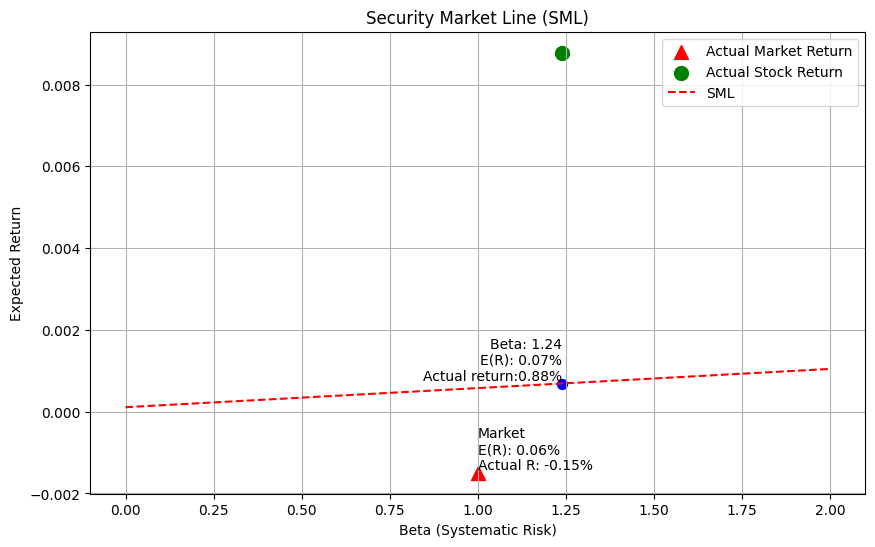

In [142]:
import matplotlib.pyplot as plt

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(beta, capm_return, color='blue', s=50)
# Add actual market return point to the scatter plot
plt.scatter(1, market_actual_return, color='red', s=100, marker='^', label='Actual Market Return')

# Add actual stock return point to the scatter plot
plt.scatter(beta, stock_actual_return, color='green', s=100, marker='o', label='Actual Stock Return')
plt.xlabel('Beta (Systematic Risk)')
plt.ylabel('Expected Return')
plt.title('Security Market Line (SML)')

# Add SML line
beta_range = np.linspace(0, 2, 100)  # Adjust range as needed
sml = rf_rate + beta_range * (m_return - rf_rate)
plt.plot(beta_range, sml, 'r--', label='SML')

# Add labels
plt.text(beta, capm_return, f'Beta: {beta:.2f}\nE(R): {capm_return:.2%}\nActual return:{stock_actual_return:.2%}', 
         verticalalignment='bottom', horizontalalignment='right')

plt.text(1, market_actual_return, f'Market\nE(R): {m_return:.2%}\nActual R: {market_actual_return:.2%}', 
         verticalalignment='bottom', horizontalalignment='left')
plt.legend()
plt.grid(True)
plt.show()

In [74]:
stock_data.tail(2)
capm_return, beta, m_return, stock_actual_return, market_actual_return = capm(stock_data, market_data)

np.nan, np.nan, np.nan, np.nan


IndexError: single positional indexer is out-of-bounds

In [ ]:
stock_data = yf.Ticker("AAPL").history(period=f"{max_period}y", interval="1d")
market_data = yf.Ticker("^GSPC").history(period=f"{max_period}y", interval="1d")
rf_data = yf.Ticker("^FVX").history(period=f"{max_period}y", interval="1d")


In [ ]:
stock_actual_return, capm_result, m_return, most_stable_period, final_beta=capm(stock_data, market_data, rf_data)
capm_result

TypeError: 'tuple' object is not callable

In [ ]:
stock_data


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-03-27 00:00:00-04:00,61.337120,62.094278,59.953851,60.121300,204216800,0.0,0.0
2020-03-30 00:00:00-04:00,60.849338,62.009344,60.524146,61.837040,167976400,0.0,0.0
2020-03-31 00:00:00-04:00,62.028770,63.700825,61.155124,61.710857,197002000,0.0,0.0
2020-04-01 00:00:00-04:00,59.820369,60.359117,58.031826,58.463795,176218400,0.0,0.0
2020-04-02 00:00:00-04:00,58.325477,59.492763,57.490661,59.439373,165934000,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-20 00:00:00-04:00,213.990005,217.490005,212.220001,214.100006,48862900,0.0,0.0
2025-03-21 00:00:00-04:00,211.559998,218.839996,211.279999,218.270004,94127800,0.0,0.0
2025-03-24 00:00:00-04:00,221.000000,221.479996,218.580002,220.729996,44299500,0.0,0.0


In [ ]:
capm(stock_data, market_data)

AttributeError: 'datetime.datetime' object has no attribute 'tz_localize'

In [ ]:

market_data['m_return'] = market_data['Close'].pct_change().dropna()
stock_data['s_return'] = stock_data['Close'].pct_change().dropna()
rf_data['rf_return'] = (rf_data['Close']/100).pct_change().dropna()
m_mean = market_data['m_return'].mean()*252*100
s_mean = stock_data['s_return'].mean()*100
rf_mean = rf_data['rf_return'].mean()*252*100
print(f"Market sp500 mean: {round(m_mean, 4)} %\nstock mean:{round(s_mean, 4)} %\nrisk free fvx mean: {round(rf_mean, 4)} %")


Market sp500 mean: 17.3723 %
stock mean:0.1179 %
risk free fvx mean: 61.5165 %


In [ ]:
import requests

url = "https://investing-com.p.rapidapi.com/markets/get-historical-data"

querystring = {"symbol":"SP500","interval":"daily","start_date":"2024-01-01","end_date":"2024-03-25"}

headers = {
    "X-RapidAPI-Key": "your_api_key_here",
    "X-RapidAPI-Host": "investing-com.p.rapidapi.com"
}

response = requests.get(url, headers=headers, params=querystring)
print(response.json())  # Returns historical market data


{'message': "API doesn't exists"}


In [ ]:
rf_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,rf_return
Date,,,,,,,,
2020-03-25 00:00:00-05:00,0.541,0.548,0.483,0.521,0,0.0,0.0,NaN
2020-03-26 00:00:00-05:00,0.498,0.521,0.449,0.478,0,0.0,0.0,-0.082534
2020-03-27 00:00:00-05:00,0.473,0.475,0.412,0.426,0,0.0,0.0,-0.108787
2020-03-30 00:00:00-05:00,0.382,0.399,0.334,0.378,0,0.0,0.0,-0.112676
2020-03-31 00:00:00-05:00,0.389,0.400,0.336,0.375,0,0.0,0.0,-0.007936
...,...,...,...,...,...,...,...,...
2025-03-19 00:00:00-05:00,4.088,4.123,4.026,4.030,0,0.0,0.0,-0.009828
2025-03-20 00:00:00-05:00,3.975,4.024,3.954,4.007,0,0.0,0.0,-0.005707
2025-03-21 00:00:00-05:00,3.980,4.014,3.961,4.008,0,0.0,0.0,0.000250


In [ ]:
df, stock_actual_return,capm, m_return, most_stable_period, final_beta= capm(stock_data, market_data, rf_data)
print(f"stock actual return: {stock_actual_return},\nCAPM: {capm},\nMarket retrun: {m_return},\nPeriod in Use: {most_stable_period},\nBeta: {final_beta}")


stock actual return: 0.0137,
CAPM: -0.8475,
Market retrun: 0.19,
Period in Use: 4,
Beta: 1.2032


C:\Users\smahd\AppData\Local\Temp\ipykernel_16636\463995252.py:121: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return model.params[1]
C:\Users\smahd\AppData\Local\Temp\ipykernel_16636\463995252.py:121: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return model.params[1]
C:\Users\smahd\AppData\Local\Temp\ipykernel_16636\463995252.py:121: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return model.params[1]
C:\Users\smahd\AppData\Lo

In [ ]:

df.to_excel('data1.xlsx', index=True)


In [ ]:
df

In [ ]:
def data(stock_data, market_data, rf_data, start_date, end_date):
    return pd.concat([df['Close'].rename(name) 
                      for df, name in zip([stock_data, market_data, rf_data], 
                                        ['Stock', 'Market', 'Risk_Free'])], axis=1) \
             .loc[start_date:end_date] \
             .dropna() \
             .pipe(lambda df: df.set_index(df.index.strftime('%Y-%m-%d')))

In [ ]:
# CAPM function 3:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta

def capm():
    # volatility calculation
    def calculate_volatility(returns):
        return returns.std() * np.sqrt(252)  # Annualized volatility
    
    # Beta calculation
    def calculate_beta(stock_returns, market_returns):
        X = sm.add_constant(market_returns.dropna())  # Add constant term
        y = stock_returns.loc[X.index]  # Ensure aligned indexes
        if len(X) < 2:  # Ensure enough data points for regression
            return np.nan
        model = sm.OLS(y, X).fit()
        return model.params[1]
    
    # calculate capm
    def calculate_capm(risk_free_rate, beta, market_return):
        return risk_free_rate + beta * (market_return - risk_free_rate)

    # get data
    max_period = 5
    end_date = datetime.now()
    start_date = end_date - timedelta(days=max_period*365)

    rf_ticker ='^IRX'
    s_ticker = 'AAPLE'
    i_ticker ='^GSPC'
    stock_data = yf.download(s_ticker, start=start_date, end=end_date)
    market_data = yf.download(i_ticker, start=start_date, end=end_date)
    rf_data = yf.download(rf_ticker, start=start_date, end=end_date)
    risk_free_rate = rf_data['Close'].iloc[-1]

    return start_date
    # # Main body
    # ## Check data
    # if stock_data.empty or market_data.empty or rf_data.empty:
    #     raise ValueError(f"Failed to fetch data for {s_ticker} or {i_ticker} or {rf_ticker}")
    
    # ## Calculate daily returns
    # stock_returns = stock_data.pct_change().dropna()
    # market_returns = market_data.pct_change().dropna()

    # # Calculate volatilities and betas
    # volatilities, betas = {}, {}
    # for period in range(1, max_period + 1):
    #     period_start = end_date - timedelta(days=period*365)
    #     period_stock_returns = stock_returns.loc[stock_returns.index >= period_start]
    #     period_market_returns = market_returns.loc[market_returns.index >= period_start]

    #     if not period_stock_returns.empty and not period_market_returns.empty:
    #         volatilities[period] = calculate_volatility(period_stock_returns)
    #         betas[period] = calculate_beta(period_stock_returns, period_market_returns)

    # # Handle case where not enough data is available
    # if len(volatilities) < 2 or len(betas) < 2:
    #     raise ValueError("Not enough data to calculate stable volatility and beta.")

    # # Convert values to numeric scalars (avoid Series-related errors)
    # volatility_changes = {p: float(abs(volatilities[p] - volatilities[p - 1])) for p in range(2, max_period + 1)}
    # if not volatility_changes:
    #     raise ValueError("Not enough stable volatility data available.")
    # # Find the most stable period
    # else:
    #     most_stable_period = min(volatility_changes, key=volatility_changes.get)
    #     final_beta = round(float(betas[most_stable_period]),4)
    
    # # Calculate expected return using CAPM
    # market_mean_return = round(market_returns.mean() * 252,4)  # Annualized return
    # CAPM = round(calculate_capm(risk_free_rate, final_beta, market_mean_return),4)
    # actual_stock_return = round((stock_returns['Close'] - stock_returns['Close'].iloc[-1])/stock_returns['Close'].iloc[-1])

    # return final_beta, most_stable_period, CAPM, market_mean_return, actual_stock_return




In [ ]:
capm()

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPLE']: YFTzMissingError('possibly delisted; no timezone found')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


datetime.datetime(2020, 3, 26, 9, 15, 33, 704684)

In [ ]:
final_beta, most_stable_period, CAPM, market_mean_return, actual_stock_return = capm()

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPLE']: YFTzMissingError('possibly delisted; no timezone found')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


ValueError: Failed to fetch data for AAPLE or ^GSPC or ^IRX

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta

def capm():
    def calculate_volatility(returns):
        return returns.std() * np.sqrt(252)  # Annualized volatility

    max_period = 5  # Maximum period in years
    end_date = datetime.now().date()  # Current date without time
    start_date = end_date - timedelta(days=max_period * 365)

    s_ticker = "AAPL"    # Stock ticker
    i_ticker = "^GSPC"   # Index (market) ticker

    # Download risk-free rate (^IRX = 13-week Treasury Bill)
    risk_free_rate_data = yf.download("^IRX", start=start_date, end=end_date)
    if risk_free_rate_data.empty:
        raise ValueError("Could not fetch risk-free rate data.")
    risk_free_rate = risk_free_rate_data["Close"].dropna().iloc[-1] / 100  # Convert from percentage

    # Download stock and market data
    stock_data = yf.download(s_ticker, start=start_date, end=end_date)
    market_data = yf.download(i_ticker, start=start_date, end=end_date)

    if stock_data.empty or market_data.empty:
        raise ValueError("Stock or market data could not be retrieved.")

    # Calculate daily returns
    stock_returns = stock_data['Close'].pct_change().dropna()
    market_returns = market_data['Close'].pct_change().dropna()

    # Ensure the index is in datetime format and extract the date
    stock_returns.index = pd.to_datetime(stock_returns.index).date
    market_returns.index = pd.to_datetime(market_returns.index).date

    volatilities = {}
    betas = {}
    valid_periods = []

    for period in range(1, max_period + 1):
        period_start = end_date - timedelta(days=period * 365)

        # Filter returns for the given period
        period_stock = stock_returns[stock_returns.index >= period_start]
        period_market = market_returns[market_returns.index >= period_start]

        if len(period_stock) > 30 and len(period_market) > 30:  # Ensure sufficient data points
            volatilities[period] = calculate_volatility(period_stock)

            # Calculate Beta
            covariance_matrix = np.cov(period_stock, period_market)
            covariance = covariance_matrix[0, 1]
            market_variance = period_market.var()

            if market_variance != 0:
                betas[period] = covariance / market_variance
                valid_periods.append(period)

    if len(valid_periods) < 2:
        raise ValueError("Insufficient data for CAPM calculation.")

    # Calculate volatility stability (absolute changes)
    volatility_changes = {
        p: abs(volatilities[p] - volatilities[p - 1])
        for p in valid_periods if (p - 1) in valid_periods
    }

    if not volatility_changes:
        raise ValueError("No valid volatility comparisons available.")

    # Find the period with the most stable volatility
    most_stable_period = min(volatility_changes, key=volatility_changes.get)

    # Use beta from the most stable period
    beta = betas.get(most_stable_period, np.nan)

    # Select returns for the most stable period
    period_start = end_date - timedelta(days=most_stable_period * 365)
    stable_stock_returns = stock_returns[stock_returns.index >= period_start]
    stable_market_returns = market_returns[market_returns.index >= period_start]

    # Calculate actual market return (annualized)
    actual_market_return = stable_market_returns.mean() * 252
    actual_return = stable_stock_returns.mean() * 252

    # Compute expected return using CAPM formula
    expected_return = risk_free_rate + beta * (actual_market_return - risk_free_rate)

    return beta, stable_stock_returns, stable_market_returns, actual_market_return, expected_return, actual_return

# Run the function
try:
    beta, stock_returns, market_returns, actual_market_return, expected_return, actual_return = calculate_capm()
    print(f"Beta: {beta:.2f}")
    print(f"Actual Market Return: {actual_market_return:.2%}")
    print(f"Expected Return: {expected_return:.2%}")
    print(f"Actual Stock Return: {actual_return:.2%}")
except ValueError as e:
    print(f"Error: {e}")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Error: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().



C:\Users\smahd\AppData\Local\Temp\ipykernel_19076\1974404302.py:53: RuntimeWarning:

Degrees of freedom <= 0 for slice

c:\Desktop\python_projects\project_env\Lib\site-packages\numpy\lib\_function_base_impl.py:2773: RuntimeWarning:

divide by zero encountered in divide

c:\Desktop\python_projects\project_env\Lib\site-packages\numpy\lib\_function_base_impl.py:2773: RuntimeWarning:

invalid value encountered in multiply



In [ ]:
beta, stable_stock_returns, stable_market_returns, actual_market_return, expected_return, actual_return = calculate_capm()


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
C:\Users\smahd\AppData\Local\Temp\ipykernel_19076\1974404302.py:53: RuntimeWarning:

Degrees of freedom <= 0 for slice

c:\Desktop\python_projects\project_env\Lib\site-packages\numpy\lib\_function_base_impl.py:2773: RuntimeWarning:

divide by zero encountered in divide

c:\Desktop\python_projects\project_env\Lib\site-packages\numpy\lib\_function_base_impl.py:2773: RuntimeWarning:

invalid value encountered in multiply



ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
# Get volatility
volatility = calculate_volatility(df["Close"])
print(volatility.isna().count())
print(volatility)
v = volatility.dropna()
print(v.isna().count())
v

6343
Date
2000-01-03 00:00:00-05:00         NaN
2000-01-04 00:00:00-05:00         NaN
2000-01-05 00:00:00-05:00         NaN
2000-01-06 00:00:00-05:00         NaN
2000-01-07 00:00:00-05:00         NaN
                               ...   
2025-03-17 00:00:00-04:00    0.282797
2025-03-18 00:00:00-04:00    0.281925
2025-03-19 00:00:00-04:00    0.288349
2025-03-20 00:00:00-04:00    0.285875
2025-03-21 00:00:00-04:00    0.288262
Name: d_volatility, Length: 6343, dtype: float64
6323


Date
2000-02-01 00:00:00-05:00    0.863021
2000-02-02 00:00:00-05:00    0.810930
2000-02-03 00:00:00-05:00    0.825911
2000-02-04 00:00:00-05:00    0.771521
2000-02-07 00:00:00-05:00    0.778120
                               ...   
2025-03-17 00:00:00-04:00    0.282797
2025-03-18 00:00:00-04:00    0.281925
2025-03-19 00:00:00-04:00    0.288349
2025-03-20 00:00:00-04:00    0.285875
2025-03-21 00:00:00-04:00    0.288262
Name: d_volatility, Length: 6323, dtype: float64

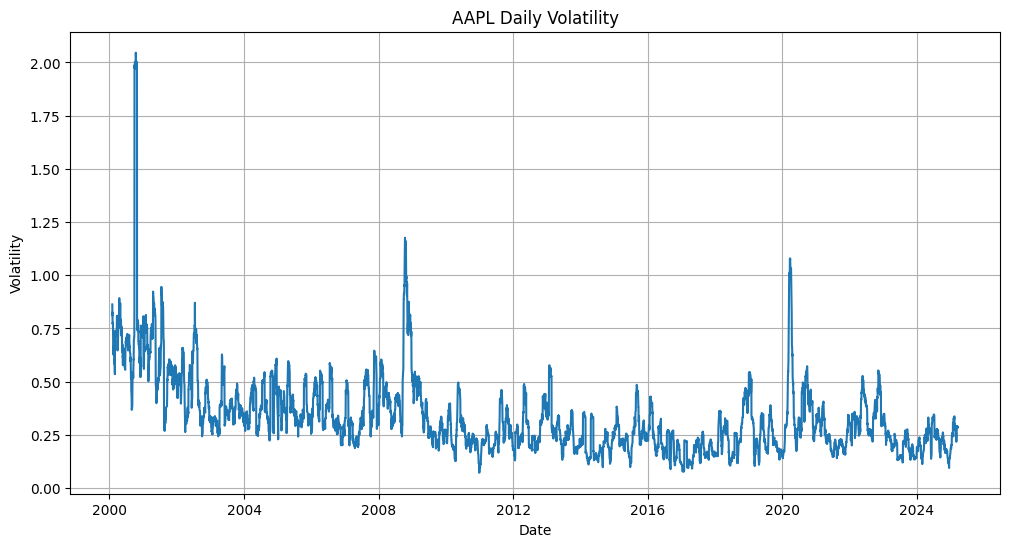

In [ ]:
# plot volatility
# Plot daily volatility
plt.figure(figsize=(12, 6))
plt.plot(volatility.index, volatility)
plt.title(f'{ticker} Daily Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(True)
plt.show()

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from datetime import datetime, timedelta

# Set up the plot
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(12, 6))
line, = ax.plot([], [], lw=2)
ax.set_xlabel('Time')
ax.set_ylabel('Volatility')
ax.set_title('Real-time Stock Volatility')
ax.grid(True)

# Initialize data
ticker = 'AAPL'  # Change this to your desired stock ticker
data = pd.DataFrame(columns=['Datetime', 'Close'])

def calculate_volatility(returns, window=20):
    return returns.rolling(window=window).std() * np.sqrt(252)

def update(frame):
    global data
    
    # Fetch the latest data
    end_time = datetime.now()
    start_time = end_time - timedelta(days=1)  # Get data for the past day
    new_data = yf.download(ticker, start=start_time, end=end_time, interval='1m')
    
    # Append new data and remove duplicates
    new_data = new_data.reset_index()
    data = pd.concat([data, new_data[['Datetime', 'Close']]])
    data = data.drop_duplicates(subset='Datetime').set_index('Datetime')
    
    # Calculate returns and volatility
    data['Returns'] = data['Close'].pct_change()
    data['Volatility'] = calculate_volatility(data['Returns'])
    
    # Update the plot
    ax.clear()
    ax.plot(data.index, data['Volatility'], lw=2)
    ax.set_xlabel('Time')
    ax.set_ylabel('Volatility')
    ax.set_title(f'Real-time {ticker} Stock Volatility')
    ax.grid(True)
    
    # Format x-axis to show time
    plt.gcf().autofmt_xdate()
    
    return line,

# Create animation that updates every 60000 milliseconds (1 minute)
ani = FuncAnimation(fig, update, interval=60000, blit=True)

plt.tight_layout()
plt.show()


OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [ ]:
update(frame)

NameError: name 'frame' is not defined

In [ ]:
from talib import RSI

# Calculate RSI
data['RSI'] = RSI(data['Close'], timeperiod=14)

# Generate signals
data['Buy Signal'] = (data['Close'] <= data['Lower Band']) & (data['RSI'] < 30)
data['Sell Signal'] = (data['Close'] >= data['Upper Band']) & (data['RSI'] > 70)

# Plot signals
ax.plot(data[data['Buy Signal']].index, data['Close'][data['Buy Signal']], '^', markersize=10, color='g', label='Buy')
ax.plot(data[data['Sell Signal']].index, data['Close'][data['Sell Signal']], 'v', markersize=10, color='r', label='Sell')


KeyError: 'Lower Band'

[*********************100%***********************]  1 of 1 completed
Traceback (most recent call last):
  File "C:\Users\smahd\AppData\Local\Temp\ipykernel_17816\2018620424.py", line 61, in update
    new_data.dropna(subset=['Datetime'], inplace=True)
  File "c:\Desktop\python_projects\project_env\Lib\site-packages\pandas\core\frame.py", line 6670, in dropna
    raise KeyError(np.array(subset)[check].tolist())
KeyError: ['Datetime']
[*********************100%***********************]  1 of 1 completed

Raw data from yfinance:
Price                           Close        High         Low        Open  \
Ticker                           AAPL        AAPL        AAPL        AAPL   
Datetime                                                                    
2025-03-21 13:30:00+00:00  212.470505  212.839996  211.470001  211.514999   
2025-03-21 13:31:00+00:00  212.419998  212.892502  212.130005  212.500000   
2025-03-21 13:32:00+00:00  211.815002  212.389999  211.710007  212.389999   
2025-03-21 13:33:00+00:00  212.175003  212.250000  211.490005  211.820007   
2025-03-21 13:34:00+00:00  212.673004  212.800003  212.119995  212.175003   

Price                        Volume  
Ticker                         AAPL  
Datetime                             
2025-03-21 13:30:00+00:00  12975516  
2025-03-21 13:31:00+00:00    284180  
2025-03-21 13:32:00+00:00    347666  
2025-03-21 13:33:00+00:00    708531  
2025-03-21 13:34:00+00:00    171571  
Columns: MultiIndex([( 'Close', 'AAPL'),
            ( 


Traceback (most recent call last):
  File "C:\Users\smahd\AppData\Local\Temp\ipykernel_17816\2018620424.py", line 61, in update
    new_data.dropna(subset=['Datetime'], inplace=True)
  File "c:\Desktop\python_projects\project_env\Lib\site-packages\pandas\core\frame.py", line 6670, in dropna
    raise KeyError(np.array(subset)[check].tolist())
KeyError: ['Datetime']


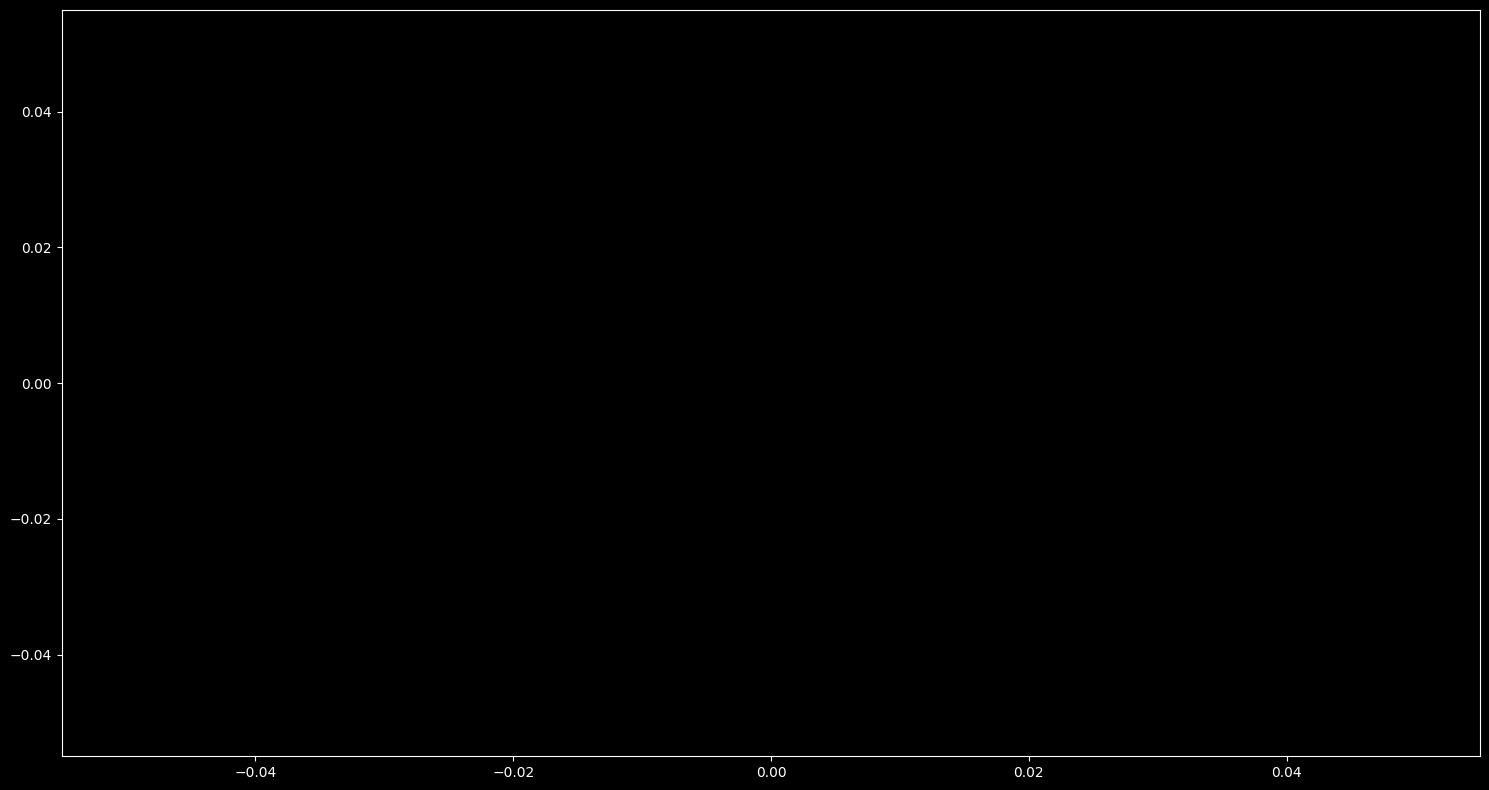

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta
import talib

# Set up the plot
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(15, 8))
line, = ax.plot([], [], lw=2)

# Initialize data
ticker = 'AAPL'
data = pd.DataFrame(columns=['Datetime', 'Close'])

def calculate_bollinger_bands(data, window=20, num_std=2):
    data['MA'] = data['Close'].rolling(window=window).mean()
    data['Std'] = data['Close'].rolling(window=window).std()
    data['Upper Band'] = data['MA'] + (data['Std'] * num_std)
    data['Lower Band'] = data['MA'] - (data['Std'] * num_std)
    return data

def calculate_volatility(returns, window=20):
    return returns.rolling(window=window).std() * np.sqrt(252)

def update(frame):
    global data
    
    try:
        # Fetch the latest data
        end_time = datetime.now()
        start_time = end_time - timedelta(days=1)
        new_data = yf.download(ticker, start=start_time, end=end_time, interval='1m')
        
        print("Raw data from yfinance:")
        print(new_data.head())
        print("Columns:", new_data.columns)
        
        if new_data.empty:
            print("No data retrieved from yfinance")
            return line,
        
        # Reset index and ensure consistent column naming
        new_data.reset_index(inplace=True)
        
        print("After reset_index:")
        print(new_data.head())
        print("Columns:", new_data.columns)
        
        # Rename 'Date' or 'Datetime' column if necessary
        if 'Date' in new_data.columns:
            new_data.rename(columns={'Date': 'Datetime'}, inplace=True)
        elif 'Datetime' not in new_data.columns:
            raise KeyError(f"Expected 'Datetime' or 'Date' column. Available columns: {new_data.columns}")
        
        # Ensure 'Datetime' column is properly formatted
        new_data['Datetime'] = pd.to_datetime(new_data['Datetime'], errors='coerce')
        new_data.dropna(subset=['Datetime'], inplace=True)
        
        print("After datetime conversion and dropping NaT:")
        print(new_data.head())
        
        if not new_data.empty:
            data = pd.concat([data, new_data[['Datetime', 'Close']]])
            data.drop_duplicates(subset='Datetime', inplace=True)
            data.set_index('Datetime', inplace=True)
            
            print("Final data structure:")
            print(data.head())
            
            # Calculate returns and volatility
            data['Returns'] = data['Close'].pct_change()
            data['Volatility'] = calculate_volatility(data['Returns'])
            
            # Calculate Bollinger Bands
            data = calculate_bollinger_bands(data)
            
            # Calculate RSI
            data['RSI'] = talib.RSI(data['Close'], timeperiod=14)
            
            # Generate signals
            data['Buy Signal'] = (data['Close'] <= data['Lower Band']) & (data['RSI'] < 30)
            data['Sell Signal'] = (data['Close'] >= data['Upper Band']) & (data['RSI'] > 70)
            
            # Update plot
            ax.clear()
            ax.plot(data.index, data['Close'], label='Price', color='white')
            ax.plot(data.index, data['Upper Band'], label='Upper BB', color='red', linestyle='--')
            ax.plot(data.index, data['Lower Band'], label='Lower BB', color='green', linestyle='--')
            ax.fill_between(data.index, data['Upper Band'], data['Lower Band'], alpha=0.1, color='gray')
            
            # Plot buy/sell signals
            ax.plot(data[data['Buy Signal']].index, 
                    data[data['Buy Signal']]['Close'], '^', markersize=10, color='lime', label='Buy')
            ax.plot(data[data['Sell Signal']].index, 
                    data[data['Sell Signal']]['Close'], 'v', markersize=10, color='red', label='Sell')
            
            ax.set_xlabel('Time')
            ax.set_ylabel('Price')
            ax.set_title(f'Real-time {ticker} Stock Price and Volatility')
            ax.grid(True, alpha=0.3)
            ax.legend()
            ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
            plt.gcf().autofmt_xdate()
        
    except Exception as e:
        print(f"Error in update: {str(e)}")
        import traceback
        traceback.print_exc()
    
    return line,

# Create animation with specified save_count
ani = FuncAnimation(fig, update, interval=60000, blit=True, save_count=100)
plt.tight_layout()
plt.show()


### Layout for showing candle stick and indicators

In [ ]:
import yfinance as yf
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# User Inputs
# ticker = input("Enter Stock Symbol (e.g., AAPL): ").upper()
# period = input("Select Time Period (e.g., 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max): ").lower()
# interval = input("Select Interval (e.g., 1m, 2m, 5m, 15m, 30m, 1h, 1d, 1wk, 1mo): ").lower()
ticker ="AAPL"
period = "1d"
interval ="1m"
print(f"Fetching data for {ticker} ({period}, {interval})...")

# Fetch stock data
try:
    
    stock = yf.Ticker(ticker)
    df = stock.history(period=period, interval=interval)
    df.reset_index(inplace=True)
    
    if df.empty:
        print("No data available. Try changing the time period or interval.")
    # else:
    #     # Ensure index is datetime for plotting
    #     df.index = df.index.tz_localize(None)
except Exception as e:
    print(f"Error fetching data: {e}")

def main_chart (df):
    # Create a subplot: 2 rows (Candlestick + Volume)
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                        vertical_spacing=0.1, row_heights=[0.7, 0.3],
                        subplot_titles=("Price Chart", "Volume"))

    # ✅ Candlestick Chart
    fig.add_trace(go.Candlestick(
        x=df.index,
        open=df['Open'],
        high=df['High'],
        low=df['Low'],
        close=df['Close'],
        name="Candlestick",
        increasing=dict(line=dict(color="green")),
        decreasing=dict(line=dict(color="red")),
    ), row=1, col=1)

    # ✅ Moving Averages
    if len(df) > 50:  # Only plot MA if enough data exists
        df["MA50"] = df["Close"].rolling(window=50).mean()
        fig.add_trace(go.Scatter(x=df.index, y=df["MA50"], mode="lines", name="50-day MA", line=dict(color="blue")), row=1, col=1)

    if len(df) > 200:
        df["MA200"] = df["Close"].rolling(window=200).mean()
        fig.add_trace(go.Scatter(x=df.index, y=df["MA200"], mode="lines", name="200-day MA", line=dict(color="red")), row=1, col=1)

    # ✅ Volume Chart
    fig.add_trace(go.Bar(
        x=df.index,
        y=df['Volume'],
        name="Volume",
        marker=dict(color="gray", opacity=0.5)
    ), row=2, col=1)

    # ✅ Add range slider & buttons
    fig.update_layout(
        title=f"{ticker} Price Chart",
        xaxis=dict(
            rangeslider=dict(visible=True),
            rangeselector=dict(
                buttons=[
                    dict(count=1, label="1d", step="minute", stepmode="backward"),
                    dict(count=1, label="1m", step="day", stepmode="backward"),
                    dict(count=3, label="3m", step="day", stepmode="backward"),
                    dict(count=6, label="6m", step="day", stepmode="backward"),
                    dict(count=1, label="YTD", step="year", stepmode="todate"),
                    dict(count=1, label="1y", step="month", stepmode="backward"),
                    dict(step="all")
                ]
            )
        ),
        height=700,
        showlegend=True
    )

    # ✅ Display chart in notebook
    fig.show()

main_chart(df)




Fetching data for AAPL (1d, 1m)...


In [ ]:
from datetime import datetime
symbol = "^IRX"
rate = yf.Ticker(symbol)
df_rate = rate.history(period="1d", interval="1d")
df_rate.reset_index(inplace=True)
# Convert to datetime format
df_rate['Date'] = pd.to_datetime(df_rate['Date'])

# Extract Date & Time separately
df_rate['date'] = df_rate['Date'].dt.date  # Extracts date (YYYY-MM-DD)
df_rate['time'] = df_rate['Date'].dt.time  # Extracts time (HH:MM:SS)


df_rate

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,date,time
0,2025-03-24 00:00:00-05:00,4.188,4.188,4.182,4.185,0,0.0,0.0,2025-03-24,00:00:00


In [ ]:
import yfinance as yf
import pandas as pd

# Fetch data
symbol = "^GSPC"
rate = yf.Ticker(symbol)
df_rate = rate.history(period="1d", interval="1d")

# Reset index to move the date from index to a column
df_rate.reset_index(inplace=True)

# Identify the main date column (it might be 'Date' or 'Datetime')
date_column = 'Date' if 'Date' in df_rate.columns else 'Datetime'

# Convert to datetime format
df_rate[date_column] = pd.to_datetime(df_rate[date_column])

# Extract Date & Time separately
df_rate['Date'] = df_rate[date_column].dt.date  # Extract date (YYYY-MM-DD)
df_rate['Time'] = df_rate[date_column].dt.time  # Extract time (HH:MM:SS)

# Drop the original main Date/Datetime column
df_rate.drop(columns=[date_column], inplace=True)

# Display the result
print(df_rate[['Date', 'Time']])  # Print only Date & Time columns

df_rate  # Display the full DataFrame


AttributeError: Can only use .dt accessor with datetimelike values